In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.metrics import confusion_matrix

In [2]:
book_dtf = pd.read_csv("C:/Users/joann/Downloads/newProject/Data_Cleaning/NLTK.csv")

In [30]:
book_dtf.head()

,Popularity,User_Reviews,Stars_Ratings,Diff_Ratings,Num_Tokenized_Words,Average_WordLength,Average_WordsinSentence,Percentage_Verbs,Percentage_Nouns,Percentage_AdjAdverb,Quote,Sentiment_Score,Tokenized_Words
0,0,18,5,0.46,14,3.500000,4.666667,0.285714,0.214286,0.071429,1,0.0000,"['prince', 'read', 'find', 'say', 'never', 'gu..."
1,0,18,5,0.53,67,4.611940,7.444444,0.134328,0.268657,0.134328,0,0.8591,"['spoiler', 'alert', 'little', 'memorial', 'fa..."
2,0,18,5,0.47,5,3.000000,2.500000,0.000000,0.400000,0.000000,0,0.5550,"['one', 'fav', 'book']"
3,0,18,5,1.14,337,4.038576,16.850000,0.225519,0.189911,0.148368,0,0.9861,"['spoiler', 'alert', 'oh', 'goodness', 'one', ..."
4,0,18,4,-0.11,52,3.807692,17.333333,0.326923,0.153846,0.115385,0,0.8807,"['think', 'great', 'educational', 'book', 'rea..."


In [31]:
book_dtf.shape

(2027673, 13)

In [3]:
#Split the dataset into 85% train set and 15% test set
#Integer is inserted to random_state to reproduce the same split everytime it is run
X_train, X_test, y_train, y_test = train_test_split(book_dtf.drop(columns=["Popularity"]), book_dtf["Popularity"],
                                                    test_size = 0.15, random_state = 229)

# Optimizing
An issue that we see in the previous model is that the model is has high error when it comes to predicting popular review due to popular review making up onlt 18% of the whole dataset, so try to combat this problem by undersampling

In [4]:
not_PopularReview_count = len(y_train[y_train==0])
PopularReview_count = len(y_train[y_train==1])
index_not_PopularReview = y_train[y_train==0].index

#Random number from the indexed of not popular review will be chosen. 
#Number of number chosen will be the difference of no. between popular and not popular reviews
rng = np.random.default_rng(seed=229)
dropped_index = rng.choice(index_not_PopularReview, not_PopularReview_count-PopularReview_count, replace=False)

#Will drop the indexes generated above, and thus we'll now have similar number of popular and not popular review in our train dataset
X_train = X_train.drop(dropped_index)
y_train = y_train.drop(dropped_index)

In [5]:
y_train.value_counts()

1    29304
0    28956
Name: Popularity, dtype: int64

In [6]:
y_test.value_counts()

0    248830
1     55534
Name: Popularity, dtype: int64

In [34]:
# Instantiate the XGBRegressor Model
# Objective = "Binary:Logitic" is used for logistic regression for binary classification (Statistical Analysis method to predict a binary outcome, such as yes or no)

# Evaluation Matrix (eval_matrix) is set to "error"
    # Calculate #(wrong case)/#(all cases). For the predictions, the evalution will regard the instances with
    # prediction value larger than 0.5 as positive instances, and the others as negative instances

# Seed variable is specified to reproduce the same result everytime the code is run
xgb_model = xgb.XGBRegressor(objective='binary:logistic', eval_metric='error', seed=229, n_jobs=-1)

In [35]:
#Parameters to try
parameters = {
    'n_estimators': (50,100,1000),
    'max_depth': (2,4,6),
    'learning_rate': (0.01, 0.1, 0.3)
}

#ShuffleSplit is used to randomly sample dataset during each iteration in order to generate a training and test set.
# n_splits set to 1, because dataset is only split to test set and train set
#test_size represents the proportion of the dataset to include in the test split. test set will be 20% of the overall data 
ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=229)

#GridSearchCV loops through the predefined parameters, and use it to fit the model on the training set.
#This way, the best parameters can be selected 
GridSearch_xgb_model = GridSearchCV(xgb_model,parameters, cv= ss )

In [ ]:
#Train the model to predict Popularity based on Non-Textual features
GridSearch_xgb_model.fit(X_train[["User_Reviews","Stars_Ratings","Diff_Ratings"]], y_train)

In [14]:
#See which parameters best fit this model
print(GridSearch_xgb_model.best_params_)

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 1000}


In [15]:
#Checking how good the predictions are on the Train Set.   
y_train_pred = GridSearch_xgb_model.predict(X_train[["User_Reviews","Stars_Ratings","Diff_Ratings"]])
y_train_pred = list(map(round,y_train_pred))

<AxesSubplot:>

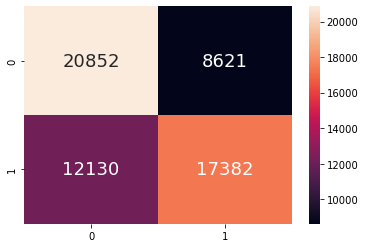

In [16]:
#Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [17]:
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
#Calculate accuracy of the prediction on train data

#Accuracy = (TP+TN)/Total data
accuracy = (confusion_matrix_train[1][1]+confusion_matrix_train[0][0])/(confusion_matrix_train[1][1]+confusion_matrix_train[1][0]+confusion_matrix_train[0][1]+confusion_matrix_train[0][0])
#TPR (True Positive Rate) = TP/(TP+FN)
TPR = confusion_matrix_train[1][1]/(confusion_matrix_train[1][1]+confusion_matrix_train[1][0])
#TNR (True Negative Rate) = TN/(TN+FP)
TNR = confusion_matrix_train[0][0]/(confusion_matrix_train[0][0]+ confusion_matrix_train[0][1])
#FPR (False Positive Rate) = FP/(TN+FP)
FPR = confusion_matrix_train[0][1]/(confusion_matrix_train[0][1]+confusion_matrix_train[0][0])
#FNR (False Negative Rate) = FN/(TP+FN)
FNR = confusion_matrix_train[1][0]/(confusion_matrix_train[1][0]+confusion_matrix_train[1][1])

print("Train Data:")
print("Accuracy  :\t", accuracy)
print("TPR Train :\t", TPR)
print("TNR Train :\t", TNR)
print("FPR Train :\t", FPR)
print("FNR Train :\t", FNR)

Train Data:
Accuracy  :	 0.6481986945833687
TPR Train :	 0.5889807535917593
TNR Train :	 0.7074949954195365
FPR Train :	 0.29250500458046347
FNR Train :	 0.4110192464082407


In [18]:
#Checking how good the predictions are on the Test Set.   
y_test_pred = GridSearch_xgb_model.predict(X_test[["User_Reviews","Stars_Ratings","Diff_Ratings"]])
y_test_pred = list(map(round,y_test_pred))

<AxesSubplot:>

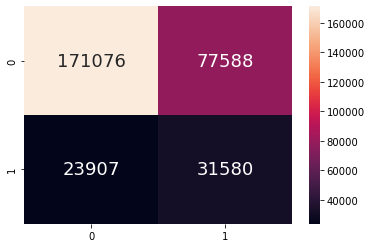

In [19]:
# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [20]:
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
#Calculate accuracy of the prediction on train data

#Accuracy = (TP+TN)/Total data
accuracy = (confusion_matrix_test[1][1]+confusion_matrix_test[0][0])/(confusion_matrix_test[1][1]+confusion_matrix_test[1][0]+confusion_matrix_test[0][1]+confusion_matrix_test[0][0])
#TPR (True Positive Rate) = TP/(TP+FN)
TPR = confusion_matrix_test[1][1]/(confusion_matrix_test[1][1]+confusion_matrix_test[1][0])
#TNR (True Negative Rate) = TN/(TN+FP)
TNR = confusion_matrix_test[0][0]/(confusion_matrix_test[0][0]+ confusion_matrix_test[0][1])
#FPR (False Positive Rate) = FP/(TN+FP)
FPR = confusion_matrix_test[0][1]/(confusion_matrix_test[0][1]+confusion_matrix_test[0][0])
#FNR (False Negative Rate) = FN/(TP+FN)
FNR = confusion_matrix_test[1][0]/(confusion_matrix_test[1][0]+confusion_matrix_test[1][1])

print("Test Data:")
print("Accuracy  :\t", accuracy)
print("TPR Train :\t", TPR)
print("TNR Train :\t", TNR)
print("FPR Train :\t", FPR)
print("FNR Train :\t", FNR)

Test Data:
Accuracy  :	 0.6663006204155173
TPR Train :	 0.5691423216248851
TNR Train :	 0.6879805681562269
FPR Train :	 0.3120194318437731
FNR Train :	 0.4308576783751149


Doing worse in terms of accuracy, but better in terms of predicting the review that are popular 

[0.4443309  0.45480874 0.10086037]


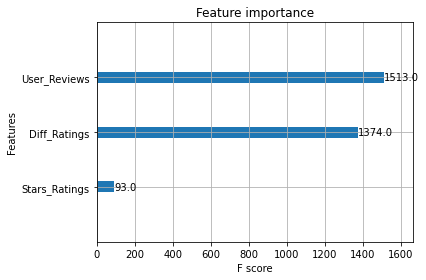

In [21]:
#Feature importance provides a score that indicates how useful each future is in the construction of the boosted decision trees within the model.
#Higher score implies that the attribute is used more to make key decision with decision trees, thus it has higher relative importance
print(GridSearch_xgb_model.best_estimator_.feature_importances_)
#Number shows weight which is the is the number of times a feature appears in a tree
xgb.plot_importance(GridSearch_xgb_model.best_estimator_)
plt.tight_layout()

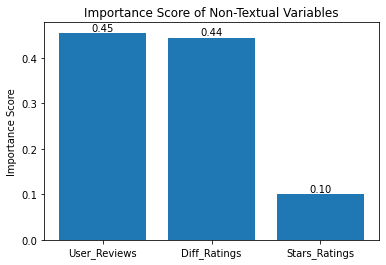

In [22]:
#Bar Plot to show Importance Score of each Non-Textual variables
variables = ('User_Reviews', 'Diff_Ratings', 'Stars_Ratings')
fig, ax = plt.subplots()
data = GridSearch_xgb_model.best_estimator_.feature_importances_
data = sorted(data, reverse=True) 
rects1 = ax.bar(variables, data, label = "Importance Score", align = "center")
ax.set_ylabel('Importance Score')
ax.set_title('Importance Score of Non-Textual Variables')
ax.bar_label(rects1, fmt='%.2f')
plt.show()

# Textual Data

In [36]:
#Try to predict popularity with Textual features:
    #Num_Tokenized_Words, Average_WordLength, Average_WordsinSentence,Percentage_Verbs,
    #Percentage_Nouns, Percentage_AdjAdverb, Quote, Sentiment_Score
    
#Perform fitting using the same conditions and parameters as Non-Textual features
GridSearch_xgb_model.fit(X_train[["Num_Tokenized_Words","Average_WordLength","Average_WordsinSentence", "Percentage_Verbs",
                   "Percentage_Nouns","Percentage_AdjAdverb", "Quote","Sentiment_Score"]], y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=229, test_size=0.2, train_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False,
                                    eval_metric='error', gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_de...
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None,
                                    objective='binary:logistic', predictor=None,
                                    random_stat

In [37]:
#Checking how good the predictions are on the Train Set.   
y_train_pred = GridSearch_xgb_model.predict(X_train[["Num_Tokenized_Words","Average_WordLength","Average_WordsinSentence", "Percentage_Verbs",
                   "Percentage_Nouns","Percentage_AdjAdverb", "Quote","Sentiment_Score"]])
y_train_pred = list(map(round,y_train_pred))

<AxesSubplot:>

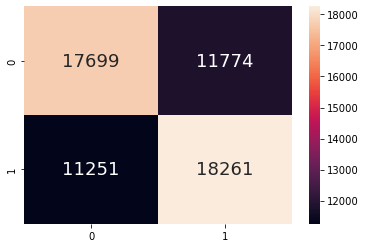

In [38]:
#Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [39]:
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
#Calculate accuracy of the prediction on train data

#Accuracy = (TP+TN)/Total data
accuracy = (confusion_matrix_train[1][1]+confusion_matrix_train[0][0])/(confusion_matrix_train[1][1]+confusion_matrix_train[1][0]+confusion_matrix_train[0][1]+confusion_matrix_train[0][0])
#TPR (True Positive Rate) = TP/(TP+FN)
TPR = confusion_matrix_train[1][1]/(confusion_matrix_train[1][1]+confusion_matrix_train[1][0])
#TNR (True Negative Rate) = TN/(TN+FP)
TNR = confusion_matrix_train[0][0]/(confusion_matrix_train[0][0]+ confusion_matrix_train[0][1])
#FPR (False Positive Rate) = FP/(TN+FP)
FPR = confusion_matrix_train[0][1]/(confusion_matrix_train[0][1]+confusion_matrix_train[0][0])
#FNR (False Negative Rate) = FN/(TP+FN)
FNR = confusion_matrix_train[1][0]/(confusion_matrix_train[1][0]+confusion_matrix_train[1][1])

print("Train Data:")
print("Accuracy  :\t", accuracy)
print("TPR Train :\t", TPR)
print("TNR Train :\t", TNR)
print("FPR Train :\t", FPR)
print("FNR Train :\t", FNR)

Train Data:
Accuracy  :	 0.6096465203017717
TPR Train :	 0.6187652480346978
TNR Train :	 0.600515726257931
FPR Train :	 0.399484273742069
FNR Train :	 0.38123475196530227


In [40]:
#Checking how good the predictions are on the Test Set.   
y_test_pred = GridSearch_xgb_model.predict(X_test[["Num_Tokenized_Words","Average_WordLength","Average_WordsinSentence", "Percentage_Verbs",
                   "Percentage_Nouns","Percentage_AdjAdverb", "Quote","Sentiment_Score"]])
y_test_pred = list(map(round,y_test_pred))

In [41]:
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
#Calculate accuracy of the prediction on train data

#Accuracy = (TP+TN)/Total data
accuracy = (confusion_matrix_test[1][1]+confusion_matrix_test[0][0])/(confusion_matrix_test[1][1]+confusion_matrix_test[1][0]+confusion_matrix_test[0][1]+confusion_matrix_test[0][0])
#TPR (True Positive Rate) = TP/(TP+FN)
TPR = confusion_matrix_test[1][1]/(confusion_matrix_test[1][1]+confusion_matrix_test[1][0])
#TNR (True Negative Rate) = TN/(TN+FP)
TNR = confusion_matrix_test[0][0]/(confusion_matrix_test[0][0]+ confusion_matrix_test[0][1])
#FPR (False Positive Rate) = FP/(TN+FP)
FPR = confusion_matrix_test[0][1]/(confusion_matrix_test[0][1]+confusion_matrix_test[0][0])
#FNR (False Negative Rate) = FN/(TP+FN)
FNR = confusion_matrix_test[1][0]/(confusion_matrix_test[1][0]+confusion_matrix_test[1][1])

print("Test Data:")
print("Accuracy  :\t", accuracy)
print("TPR Train :\t", TPR)
print("TNR Train :\t", TNR)
print("FPR Train :\t", FPR)
print("FNR Train :\t", FNR)

Test Data:
Accuracy  :	 0.5979792931800323
TPR Train :	 0.6185412799394453
TNR Train :	 0.5933910819418975
FPR Train :	 0.4066089180581025
FNR Train :	 0.3814587200605547


Less accurate than Non-Textual features, but follow same trend

[0.57746    0.10797084 0.01863669 0.07968307 0.11081652 0.03462087
 0.03919541 0.03161663]


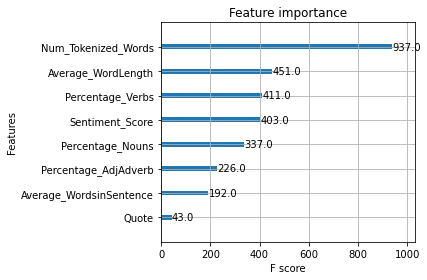

In [28]:
#Feature importance provides a score that indicates how useful each future is in the construction of the boosted decision trees within the model.
#Higher score implies that the attribute is used more to make key decision with decision trees, thus it has higher relative importance
print(GridSearch_xgb_model.best_estimator_.feature_importances_)
#Number shows weight which is the is the number of times a feature appears in a tree
xgb.plot_importance(GridSearch_xgb_model.best_estimator_)
plt.tight_layout()

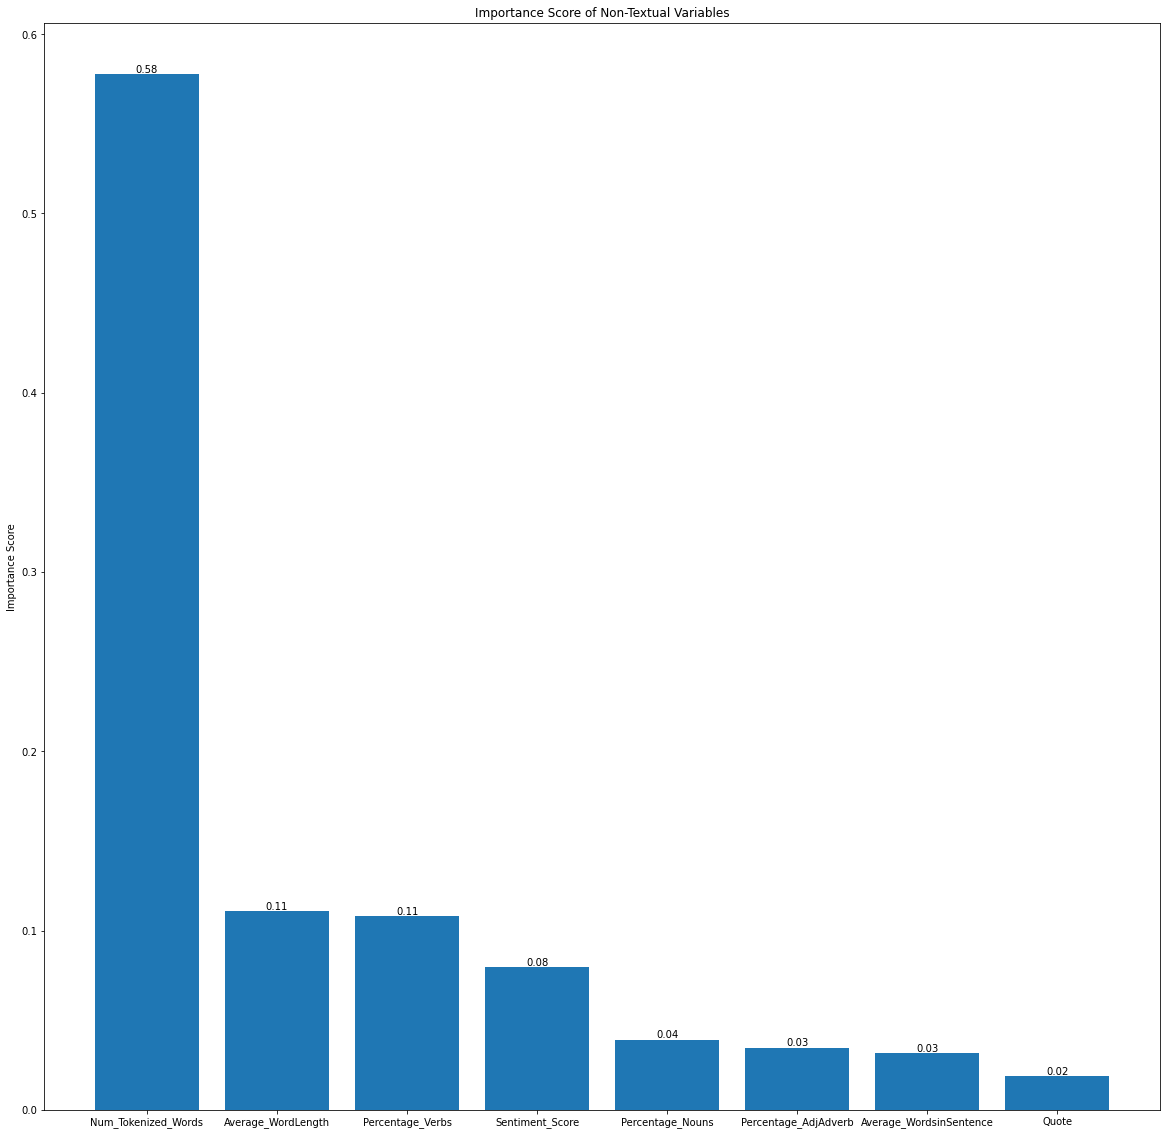

In [30]:
#Bar Plot to show Importance Score of each Non-Textual variables
variables = ("Num_Tokenized_Words", "Average_WordLength", "Percentage_Verbs", 'Sentiment_Score', 'Percentage_Nouns', 'Percentage_AdjAdverb', "Average_WordsinSentence","Quote" )
fig, ax = plt.subplots(figsize=(20,20))
data = GridSearch_xgb_model.best_estimator_.feature_importances_
data = sorted(data, reverse=True) 
rects1 = ax.bar(variables, data, label = "Importance Score", align = "center")
ax.set_ylabel('Importance Score')
ax.set_title('Importance Score of Non-Textual Variables')
ax.bar_label(rects1, fmt='%.2f')
plt.show()

In [31]:
#Now let's try to predict using both Textual and Non-textual characteristics

#Split the dataset into 85% train set and 15% test set
#Integer is inserted to random_state to reproduce the same split everytime it is run

#Perform fitting using the same conditions and parameters as Non-Textual features
GridSearch_xgb_model.fit(X_train[["User_Reviews","Stars_Ratings","Diff_Ratings", "Num_Tokenized_Words","Average_WordLength","Average_WordsinSentence", "Percentage_Verbs",
                   "Percentage_Nouns","Percentage_AdjAdverb", "Quote","Sentiment_Score"]], y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=229, test_size=0.2, train_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False,
                                    eval_metric='error', gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_de...
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None,
                                    objective='binary:logistic', predictor=None,
                                    random_stat

In [32]:
#See which parameters best fit this model
print(GridSearch_xgb_model.best_params_)

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}


In [33]:
#Checking how good the predictions are on the Train Set.   
y_train_pred = GridSearch_xgb_model.predict(X_train[["User_Reviews","Stars_Ratings","Diff_Ratings", "Num_Tokenized_Words","Average_WordLength","Average_WordsinSentence", "Percentage_Verbs",
                   "Percentage_Nouns","Percentage_AdjAdverb", "Quote","Sentiment_Score"]])
y_train_pred = list(map(round,y_train_pred))

<AxesSubplot:>

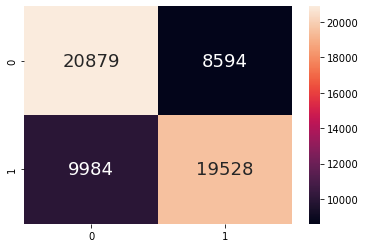

In [34]:
#Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [35]:
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
#Calculate accuracy of the prediction on train data

#Accuracy = (TP+TN)/Total data
accuracy = (confusion_matrix_train[1][1]+confusion_matrix_train[0][0])/(confusion_matrix_train[1][1]+confusion_matrix_train[1][0]+confusion_matrix_train[0][1]+confusion_matrix_train[0][0])
#TPR (True Positive Rate) = TP/(TP+FN)
TPR = confusion_matrix_train[1][1]/(confusion_matrix_train[1][1]+confusion_matrix_train[1][0])
#TNR (True Negative Rate) = TN/(TN+FP)
TNR = confusion_matrix_train[0][0]/(confusion_matrix_train[0][0]+ confusion_matrix_train[0][1])
#FPR (False Positive Rate) = FP/(TN+FP)
FPR = confusion_matrix_train[0][1]/(confusion_matrix_train[0][1]+confusion_matrix_train[0][0])
#FNR (False Negative Rate) = FN/(TP+FN)
FNR = confusion_matrix_train[1][0]/(confusion_matrix_train[1][0]+confusion_matrix_train[1][1])

print("Train Data:")
print("Accuracy  :\t", accuracy)
print("TPR Train :\t", TPR)
print("TNR Train :\t", TNR)
print("FPR Train :\t", FPR)
print("FNR Train :\t", FNR)

Train Data:
Accuracy  :	 0.6850385691277443
TPR Train :	 0.6616969368392518
TNR Train :	 0.7084110881145456
FPR Train :	 0.2915889118854545
FNR Train :	 0.33830306316074815


In [36]:
#Checking how good the predictions are on the Test Set.   
y_test_pred = GridSearch_xgb_model.predict(X_test[["User_Reviews","Stars_Ratings","Diff_Ratings", "Num_Tokenized_Words","Average_WordLength","Average_WordsinSentence", "Percentage_Verbs",
                   "Percentage_Nouns","Percentage_AdjAdverb", "Quote","Sentiment_Score"]])
y_test_pred = list(map(round,y_test_pred))

<AxesSubplot:>

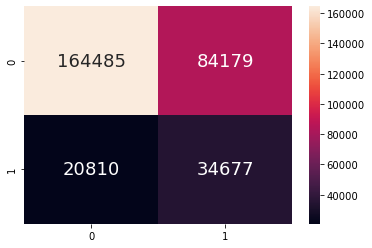

In [37]:
# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [38]:
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
#Calculate accuracy of the prediction on train data

#Accuracy = (TP+TN)/Total data
accuracy = (confusion_matrix_test[1][1]+confusion_matrix_test[0][0])/(confusion_matrix_test[1][1]+confusion_matrix_test[1][0]+confusion_matrix_test[0][1]+confusion_matrix_test[0][0])
#TPR (True Positive Rate) = TP/(TP+FN)
TPR = confusion_matrix_test[1][1]/(confusion_matrix_test[1][1]+confusion_matrix_test[1][0])
#TNR (True Negative Rate) = TN/(TN+FP)
TNR = confusion_matrix_test[0][0]/(confusion_matrix_test[0][0]+ confusion_matrix_test[0][1])
#FPR (False Positive Rate) = FP/(TN+FP)
FPR = confusion_matrix_test[0][1]/(confusion_matrix_test[0][1]+confusion_matrix_test[0][0])
#FNR (False Negative Rate) = FN/(TP+FN)
FNR = confusion_matrix_test[1][0]/(confusion_matrix_test[1][0]+confusion_matrix_test[1][1])

print("Test Data:")
print("Accuracy  :\t", accuracy)
print("TPR Train :\t", TPR)
print("TNR Train :\t", TNR)
print("FPR Train :\t", FPR)
print("FNR Train :\t", FNR)

Test Data:
Accuracy  :	 0.6548129054318415
TPR Train :	 0.6249571971813217
TNR Train :	 0.6614749219830776
FPR Train :	 0.33852507801692244
FNR Train :	 0.37504280281867824


highest accuracy, still follows the same trend

[0.30860743 0.08699179 0.06116884 0.19042934 0.06619699 0.04307543
 0.0510855  0.05489631 0.04459617 0.05295441 0.03999772]


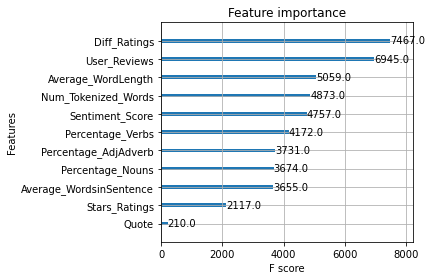

In [39]:
#Feature importance provides a score that indicates how useful each future is in the construction of the boosted decision trees within the model.
#Higher score implies that the attribute is used more to make key decision with decision trees, thus it has higher relative importance
print(GridSearch_xgb_model.best_estimator_.feature_importances_)
#Number shows weight which is the is the number of times a feature appears in a tree
xgb.plot_importance(GridSearch_xgb_model.best_estimator_)
plt.tight_layout()